In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
#os.environ["CUDA_VISIBLE_DEVICES"]=""
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%load_ext autoreload
%autoreload 2

from i3cols_dataloader import load_data

import matplotlib.animation as animation

import gc

from tqdm import tqdm

import dragoman as dm
from dragoman.utils.stats import weighted_quantile

from transformations import trafo_indep, trafo_q

%load_ext line_profiler

In [3]:
plt.rcParams['figure.figsize'] = [12., 8.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [4]:
tf.test.is_gpu_available()

True

# Load NNs

In [8]:
hit_net = tf.keras.models.load_model('models/new_hit_net.h5', custom_objects={'trafo_indep':trafo_indep})

In [9]:
charge_net = tf.keras.models.load_model('models/new_charge_net.h5', custom_objects={'trafo_q':trafo_q})

# Test NNs
Using an independent MC file

In [6]:
single_hits, repeated_params, total_charge, params, labels = load_data(dir='/home/iwsatlas1/peller/work/oscNext/level7_v01.04/140000_i3cols_test')

In [491]:
def get_llhs(hits, charges, hitcharges, params, epsilon = 1e-10, subtract=True):
    
    if params.ndim == 1:
        params = np.array([params])
    
    N = params.shape[0]
    n_hits = hits.shape[0]
    
    q_charges = np.repeat(charges, repeats=N)
    q_llh = charge_net.predict([q_charges[:, np.newaxis], params], batch_size=4096)
    q_llh = q_llh[:, 0]
    q_llh = np.clip(q_llh, epsilon, 1-epsilon)
    q_llh = -(np.log(q_llh) - np.log(1 - q_llh))
    
    
    if len(hits) > 0:
        params = np.repeat(params[np.newaxis, :], repeats=n_hits, axis=0).reshape(n_hits*N, -1)
        hits = np.repeat(hits[:, np.newaxis, :], repeats=N, axis=1).reshape(n_hits*N, -1)

        #%time
        likelihood = hit_net.predict([hits, params], batch_size=2**15)
        likelihood = likelihood.reshape(n_hits, N)
        likelihood = np.clip(likelihood, epsilon, 1-epsilon)
        llhs = -(np.log(likelihood) - np.log(1 - likelihood))
        
        
        all_hits = hitcharges @ llhs
        if subtract:
            all_hits -= np.min(all_hits)
        
    else:
        all_hits = 0.
        llhs = np.array([])

    if subtract:
        q_llh -= np.min(q_llh)
    
    total_llh = all_hits + q_llh
    
    if subtract:    
        total_llh -= np.min(total_llh)
    
    return llhs.T, all_hits, q_llh, total_llh

In [13]:
def get_llh_2d(event_idx, plot_dim_x, plot_dim_y, n_steps=100):
    plot_idx_x = labels.index(plot_dim_x)
    true_p_x = pf[event_idx][plot_idx_x]
    plot_idx_y = labels.index(plot_dim_y)
    true_p_y = pf[event_idx][plot_idx_y]

    if plot_dim_x == 'zenith':
        xs = np.linspace(0, np.pi, n_steps)
    elif plot_dim_x == 'azimuth':
        xs = np.linspace(0, 2*np.pi, n_steps)
    elif 'energy' in plot_dim_x:
        xs = np.linspace(0, min(max(10, 10*true_p_x), 1000), n_steps)
    else:
        delta = 150
        if plot_dim_x == 'time':
            delta *= 3
        xs = np.linspace(true_p_x-delta, true_p_x+delta, n_steps)

        
    if plot_dim_y == 'zenith':
        ys = np.linspace(0, np.pi, n_steps)
    elif plot_dim_y == 'azimuth':
        ys = np.linspace(0, 2*np.pi, n_steps)
    elif 'energy' in plot_dim_y:
        ys = np.linspace(0, min(max(10, 10*true_p_y), 1000), n_steps)
    else:
        delta = 150
        if plot_dim_y == 'time':
            delta *= 3
        ys = np.linspace(true_p_y-delta, true_p_y+delta, n_steps)    

    p = dm.GridData(**{plot_dim_x:xs, plot_dim_y:ys})
    
    params = np.repeat(pf[event_idx][np.newaxis, :], repeats=p.grid.size, axis=0)
    params[:, plot_idx_x] = p[plot_dim_x].flatten()
    params[:, plot_idx_y] = p[plot_dim_y].flatten()
    
    
    llhs, all_hits, q_llh, total_llh = get_llhs(hf[event_idx], qf[event_idx], cf[event_idx], params)
    
    p['q_llh'] = q_llh.reshape(p.grid.shape)
    p['llhs'] = llhs.reshape(p.grid.shape + (-1,))
    p['llh'] = all_hits.reshape(p.grid.shape)
    p['tot'] = total_llh.reshape(p.grid.shape)
    
    return p, (true_p_x, true_p_y)

In [14]:
def get_llh_1d(event_idx, plot_dim, n_steps=100):

    plot_idx = labels.index(plot_dim)
    true_p = pf[event_idx][plot_idx]

    if plot_dim == 'zenith':
        xs = np.linspace(0, np.pi, n_steps)
    elif plot_dim == 'azimuth':
        xs = np.linspace(0, 2*np.pi, n_steps)
    elif 'energy' in plot_dim:
        xs = np.linspace(0, min(max(10, 10*true_p), 1000), n_steps)
    else:
        delta = 50
        if plot_dim == 'time':
            delta *= 3
        xs = np.linspace(true_p-delta, true_p+delta, n_steps)    

    params = np.repeat(pf[event_idx][np.newaxis, :], repeats=n_steps, axis=0)#.reshape(-1, 2)
    params[:, plot_idx] = xs
    
    return xs, get_llhs(hf[event_idx], qf[event_idx], cf[event_idx], params)

CPU times: user 47.5 s, sys: 4.58 s, total: 52.1 s
Wall time: 5.84 s


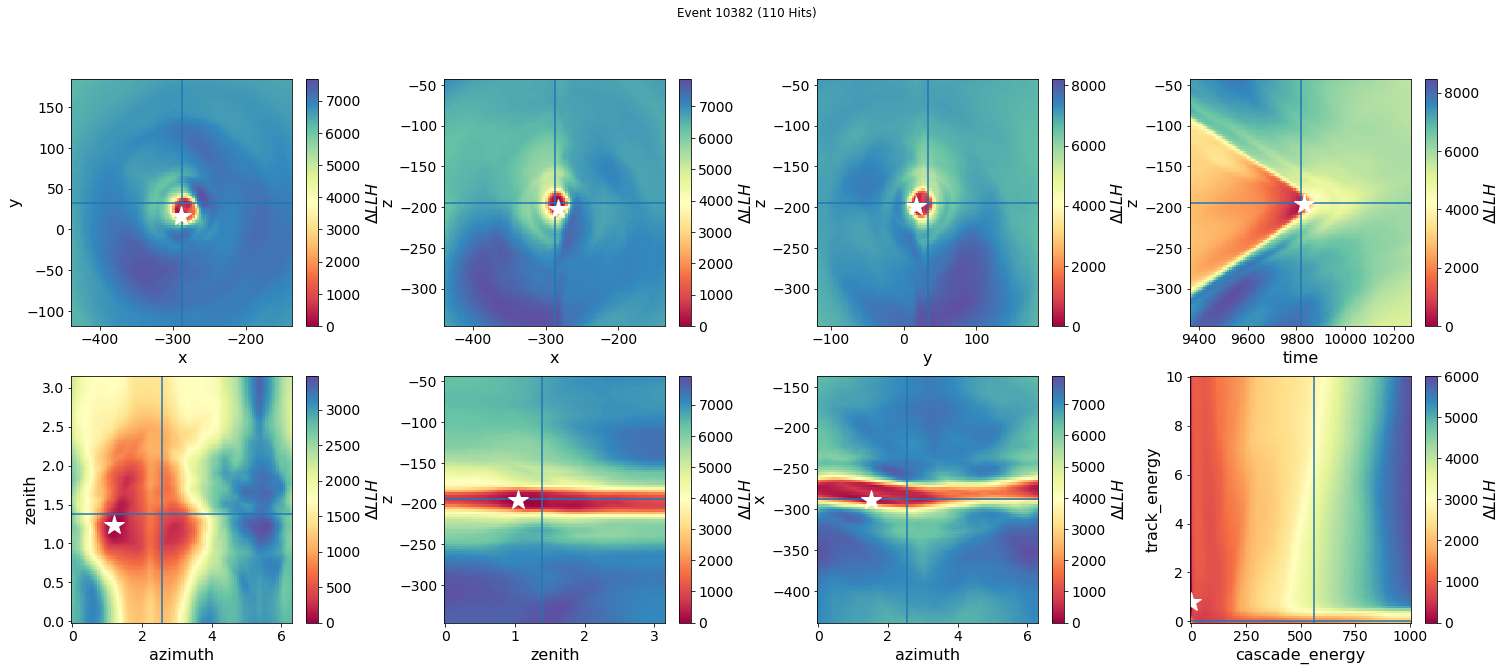

In [15]:
%%time
#event_idx = 666 # 666 #4242
event_idx = np.random.randint(0, len(pf)-1) #12321 #1657

fig, ax = plt.subplots(2,4, figsize=(25, 10))
plt.subplots_adjust(wspace=0.35)

def plot_2d(x, y, ax):
    p, t = get_llh_2d(event_idx, x, y, n_steps=100)
    p.plot('tot', cbar=True, cmap='Spectral', ax=ax, label=r'$\Delta LLH$')
    ax.axvline(t[0])
    ax.axhline(t[1])
    max_idx = np.unravel_index(np.argmin(p['tot']), p.grid.shape)
    ax.plot(p[x][max_idx],  p[y][max_idx], marker='*', color='w', lw=0, ms=20, label='MLE')

    
plot_2d('x', 'y', ax[0,0])
plot_2d('x', 'z', ax[0,1])
plot_2d('y', 'z', ax[0,2])
plot_2d('time', 'z', ax[0,3])
plot_2d('azimuth', 'zenith', ax[1,0])
plot_2d('zenith', 'z', ax[1,1])
plot_2d('azimuth', 'x', ax[1,2])
plot_2d('cascade_energy', 'track_energy', ax[1,3])

fig.suptitle('Event %i (%i Hits)'%(event_idx,hf[event_idx].shape[0]))
plt.savefig('plots/Event_%i.png'%event_idx, dpi=300)

In [16]:
def plot_llh(event_idx, plot_dim, ax, n_steps=100):
    n_hits = hf[event_idx].shape[0]
    
    colors = plt.cm.Wistia(np.linspace(0,1,n_hits))
    plot_idx = labels.index(plot_dim)

    xs, (llhs, all_hits, q_llh, total_llh) = get_llh_1d(event_idx, plot_dim, n_steps=n_steps)
    
    #llh = np.nan_to_num(llh)
    
    for i in range(n_hits):
        label = 'Single Hit' if i == n_hits//2 else None
        ax.plot(xs, llhs[:,i] - np.min(llhs[:,i]), c=colors[i], alpha=0.8, label=label)
    
    ax.axvline(pf[event_idx][plot_idx], c='r', label='truth')
    ax.plot(xs, all_hits, c='deepskyblue', ls='-', lw=2, label='All Hits')
    ax.plot(xs, q_llh, c='green', lw=2, label='Charge')
    ax.plot(xs, total_llh, c='k', lw=2, label='Total')
    ax.axvline(xs[np.argmin(total_llh)], c='k', ls='--', label='Minimum')
    
    ax.set_xlabel(plot_dim)
    #plt.legend()

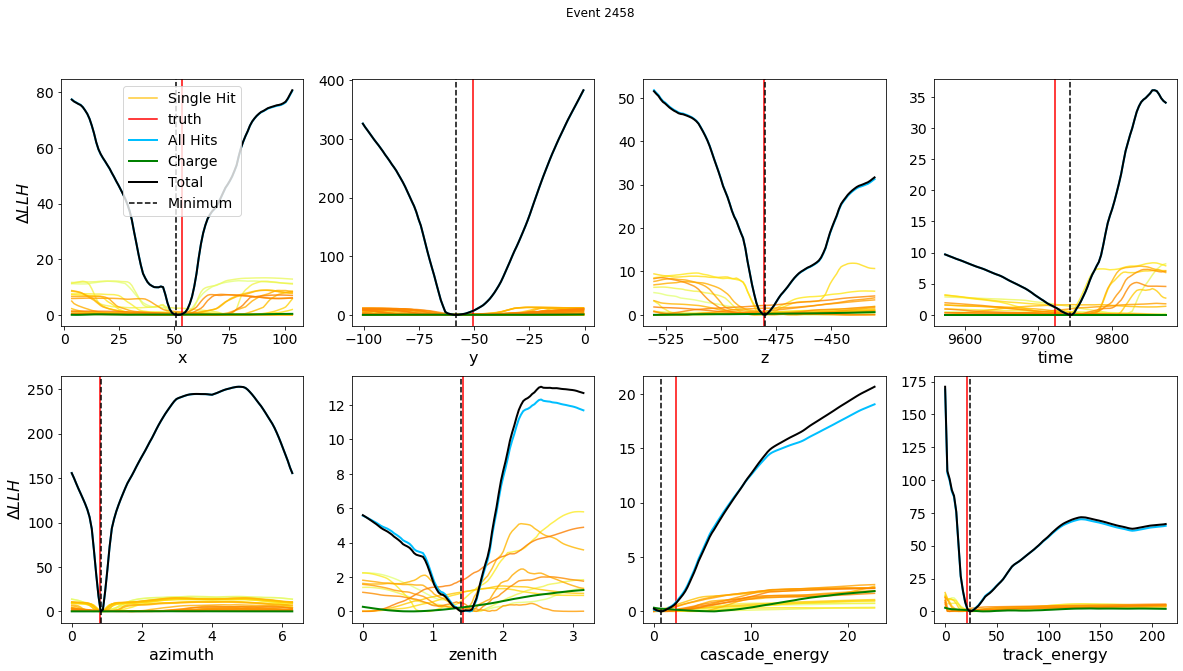

In [17]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10)) #, sharey=True)

for i in range(ax.size):

    axis = ax[i//4, i%4]

    
    if i >= len(labels):
        axis.set_axis_off()
        continue
    
    #evt = 1756 
    evt = np.random.randint(0, len(pf)-1)
    #evt = 666
    #evt = 12561
    
    plot_llh(evt, labels[i], axis, n_steps=100) #1756, 987
    
    if i == 0:
        axis.legend()
        
        
    if i%4 == 0:
        axis.set_ylabel(r'$\Delta LLH$')

        
fig.suptitle('Event %i'%evt)
        
plt.savefig('plots/hitnet_event%i.png'%evt)

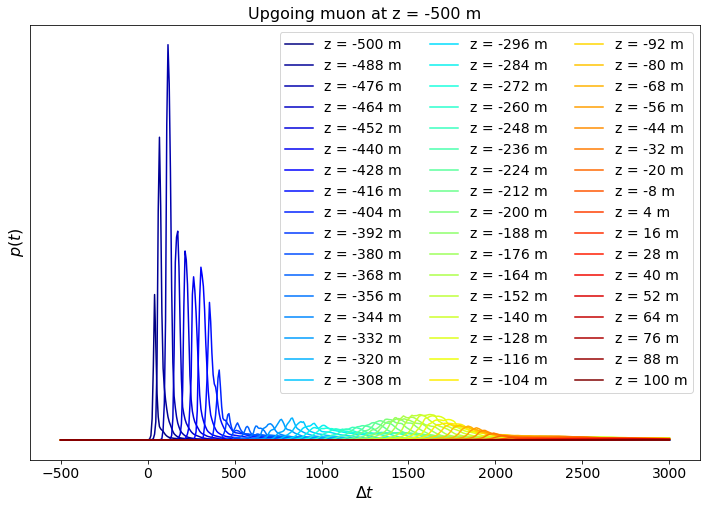

In [185]:
N = 51

colors = plt.cm.jet(np.linspace(0,1,N))

fig, ax = plt.subplots(1,1)

def animate(muon_z):

    
    ax.clear()

    for i, z in enumerate(np.linspace(-500, 100, N)):

        p = np.repeat(np.array([0., 0., muon_z, 0, 0., np.pi, 20., 100.]), 500).reshape(8, -1).T


        p[:, 3] = np.linspace(-3000, 500, p.shape[0])


        _, l, _, _, = get_llhs(np.array([[5.,5., z, 0.]]), [1.], [1.], p, epsilon = 1e-10, subtract=False)

        ax.plot(-p[:, 3], np.exp(-l), color=colors[i], label='z = %.0f m'%z)
    ax.legend(ncol=3, loc='upper right')
    ax.get_yaxis().set_ticks([])
    ax.set_title(f'Upgoing muon at z = {muon_z:.0f} m')
    ax.set_xlabel(r'$\Delta t$')
    ax.set_ylabel(r'$p(t)$')
        
    
ani = animation.FuncAnimation(fig, animate, frames=np.linspace(-500, -200, 100))


#plt.gca().set_yscale('log')
#plt.savefig('upgoing_muon.png')

In [186]:
ani.save('muon.gif', writer='imagemagick', fps=25)

In [ ]:
N = 51


colors = plt.cm.jet(np.linspace(0,1,N))

for i, z in enumerate(np.linspace(-500, 100, N)):

    p = np.repeat(np.array([0., 0., -450., 0, 0., np.pi, 20., 100.]), 500).reshape(8, -1).T


    p[:, 3] = np.linspace(-3000, 500, p.shape[0])


    _, l, _, _, = get_llhs(np.array([[5.,5., z, 0.]]), [1.], [1.], p, epsilon = 1e-10, subtract=False)

    plt.plot(-p[:, 3], np.exp(-l), color=colors[i], label='z = %.0f m'%z)
plt.legend(ncol=3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().set_title('Upgoing Muon')
plt.gca().set_xlabel(r'$\Delta t$')
plt.gca().set_ylabel(r'$p(t)$')
#plt.gca().set_yscale('log')
#plt.savefig('upgoing_muon.png')

In [19]:
labels

['x', 'y', 'z', 'time', 'azimuth', 'zenith', 'cascade_energy', 'track_energy']

In [39]:
qs = []
N = 21

charges = np.linspace(10, 500, 100)
xs = np.logspace(0, 3, N)
xs = np.linspace(0, 500, N)

for charge in charges:
    p = np.repeat(np.array([0., 0., -300., 0, np.pi, 0, 0., 0.]), N).reshape(8, -1).T
    p[:, 6] = xs
    _, l, q, _, = get_llhs(np.array([]), [charge], [1.], p, epsilon = 1e-10, subtract=False)
    qs.append(q)

qs = np.array(qs)

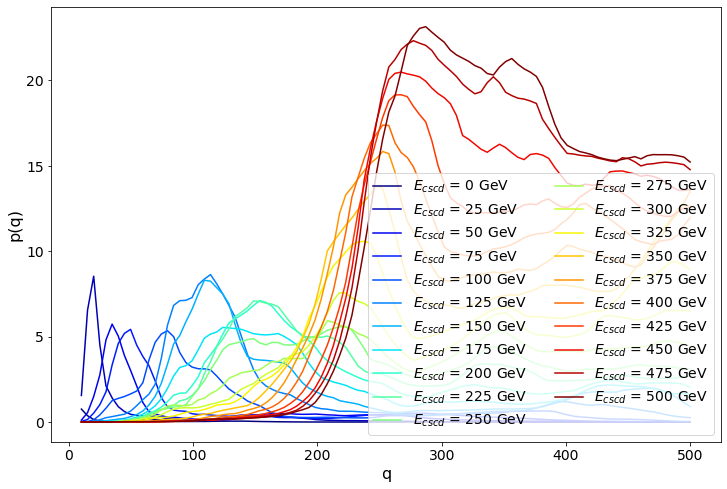

In [42]:
colors = plt.cm.jet(np.linspace(0,1,len(xs)))

for i in range(len(xs)):
    q = qs[:,i]
    #q -= np.min(q)
    plt.plot(charges, np.exp(-q), color = colors[i], label=r'$E_{cscd}$ = %i GeV'%xs[i]);
    
plt.gca().set_xlabel('q')
plt.gca().set_ylabel('p(q)')
plt.legend(loc="lower right", ncol=2)

In [23]:
geo = np.load('geo_array.npy')

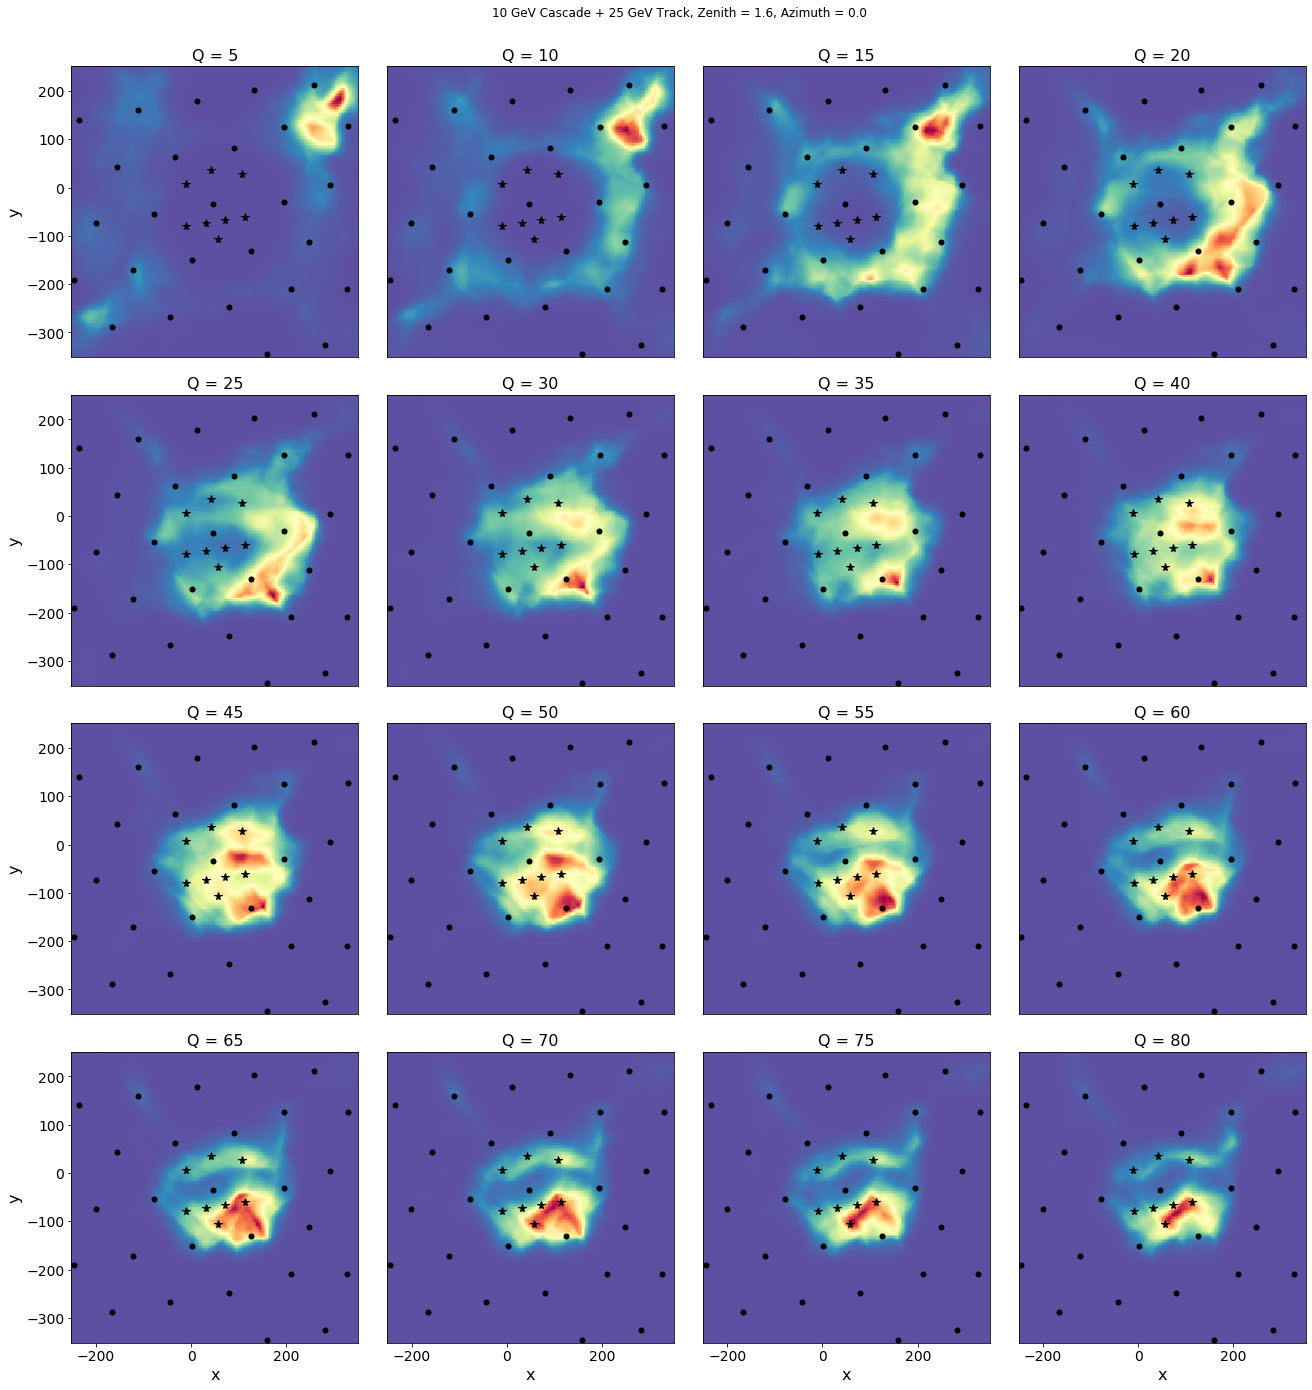

In [168]:
fig, ax = plt.subplots(4, 4, figsize=(18, 20))

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0.1)

N = 201

charges = np.linspace(5, 80, 16)


def animate(az):

    for i in range(len(charges)):

        g = dm.GridData(x = np.linspace(-250, 350, N), y= np.linspace(-350, 250, N))

        par = np.array([0., 0., -360., 0, az, np.pi/2., 10., 25.])

        p = np.repeat(par, N*N).reshape(8, -1).T
        p[:, 0] = g['x'].flatten()
        p[:, 1] = g['y'].flatten()
        _, l, q, _, = get_llhs(np.array([]), [charges[i]], [1.], p, epsilon = 1e-10, subtract=False)


        g['q'] = q.reshape(g.grid.shape)
        g['p'] = np.exp(-g['q'])

        axis = ax[i//4, i%4]

        axis.clear()

        g.plot('p', cmap='Spectral_r', ax=axis) #, cbar=True)
        axis.set_title('Q = %.0f'%charges[i])

        if not i//4 == 3:
            axis.get_xaxis().set_visible(False)
        if i%4:
            axis.get_yaxis().set_visible(False)



        axis.plot(geo[:78, 0, 0], geo[:78, 0, 1], 'o', color='k', ms=5)
        axis.plot(geo[78:, 0, 0], geo[78:, 0, 1], '*', color='k', ms=8)
        
        fig.suptitle(f'{par[6]:.0f} GeV Cascade + {par[7]:.0f} GeV Track, Zenith = {par[5]:.1f}, Azimuth = {par[4]:.1f}')
        
#plt.savefig('cascade_25GeV.png')

ani = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 2*np.pi, 100))


In [169]:
ani.save('test.gif', writer='imagemagick', fps=25)

<Figure size 864x576 with 0 Axes>

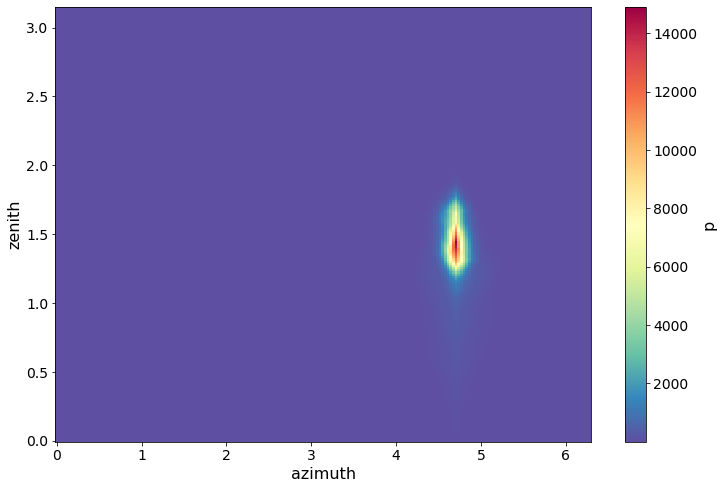

In [112]:
g = dm.GridData(azimuth = np.linspace(0, 2*np.pi, N), zenith= np.linspace(0, np.pi, N))

par = np.array([0., 0., -250., 0,0, 0, 20., 20.])

p = np.repeat(par, N*N).reshape(8, -1).T
p[:, 4] = g['azimuth'].flatten()
p[:, 5] = g['zenith'].flatten()
_, l, q, _, = get_llhs(np.array([[0.,20., -250, 50.]]), [1.], [1.], p, epsilon = 1e-10, subtract=False)


g['l'] = l.reshape(g.grid.shape)
g['p'] = np.exp(-g['l'])


g.plot('p', cmap='Spectral_r', cbar=True)
    

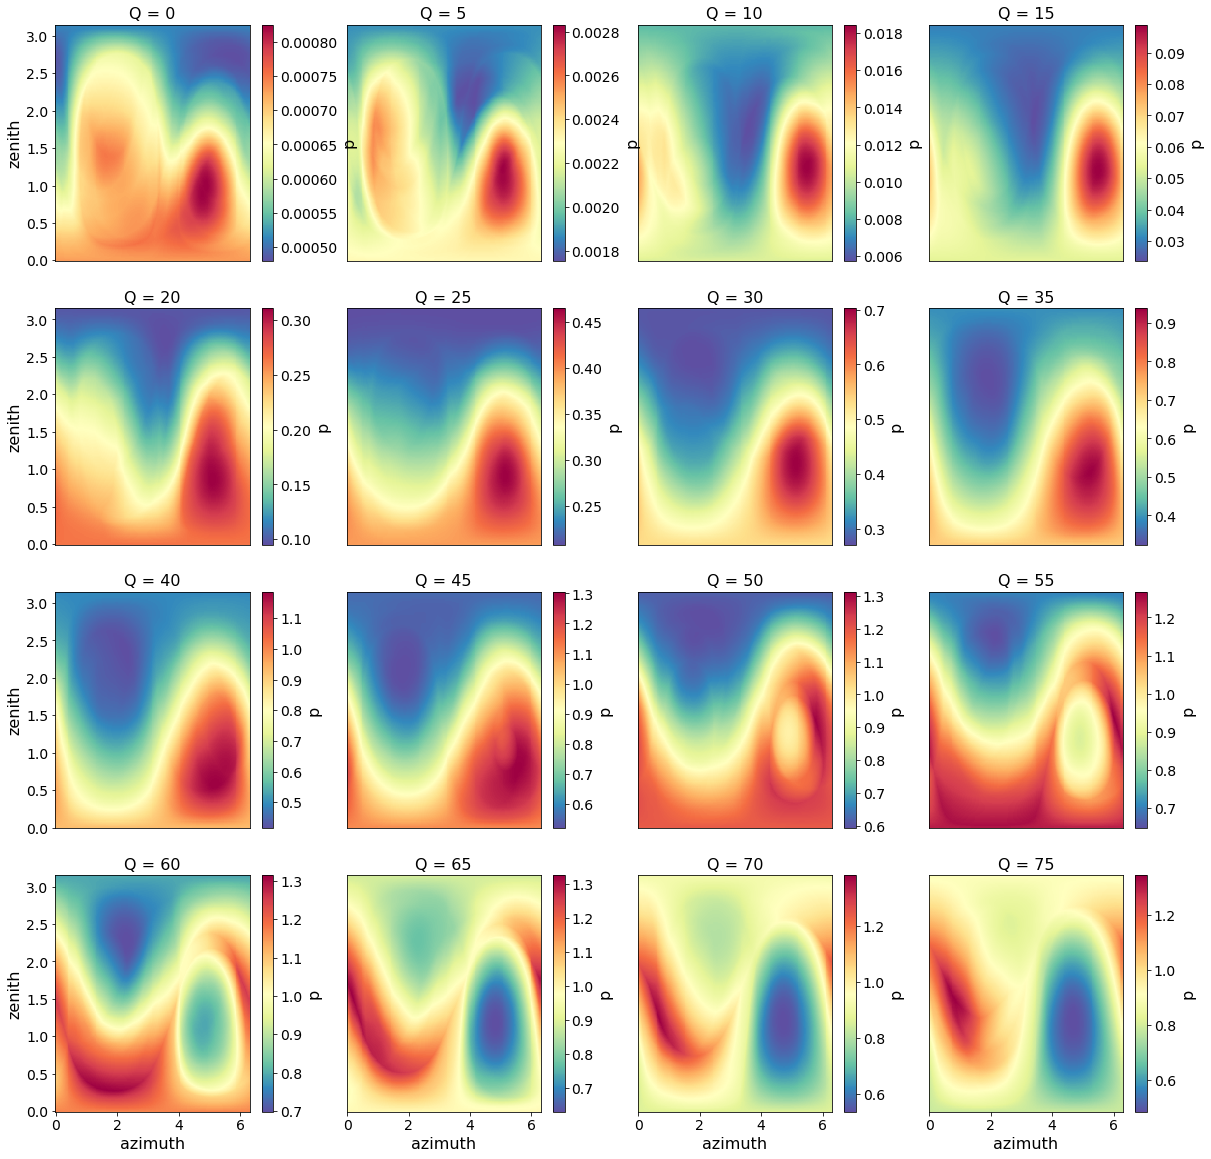

In [124]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))


N = 201

charges = np.linspace(0, 75, 16)


for i in range(len(charges)):
    
    g = dm.GridData(azimuth = np.linspace(0, 2*np.pi, N), zenith= np.linspace(0, np.pi, N))

    par = np.array([50., -50., -350., 0,0, 0, 0., 50.])

    p = np.repeat(par, N*N).reshape(8, -1).T
    p[:, 4] = g['azimuth'].flatten()
    p[:, 5] = g['zenith'].flatten()
    _, l, q, _, = get_llhs(np.array([]), [charges[i]], [1.], p, epsilon = 1e-10, subtract=False)


    g['q'] = q.reshape(g.grid.shape)
    g['p'] = np.exp(-g['q'])

    axis = ax[i//4, i%4]
    
    g.plot('p', cmap='Spectral_r', ax=axis, cbar=True)
    axis.set_title('Q = %.0f'%charges[i])
    
    if not i//4 == 3:
        axis.get_xaxis().set_visible(False)
    if i%4:
        axis.get_yaxis().set_visible(False)
        
    
    
    #axis.plot(geo[:78, 0, 0], geo[:78, 0, 1], 'o', color='k', ms=5)
    #axis.plot(geo[78:, 0, 0], geo[78:, 0, 1], '*', color='k', ms=8)
        
#plt.savefig('cascade_25GeV.png')

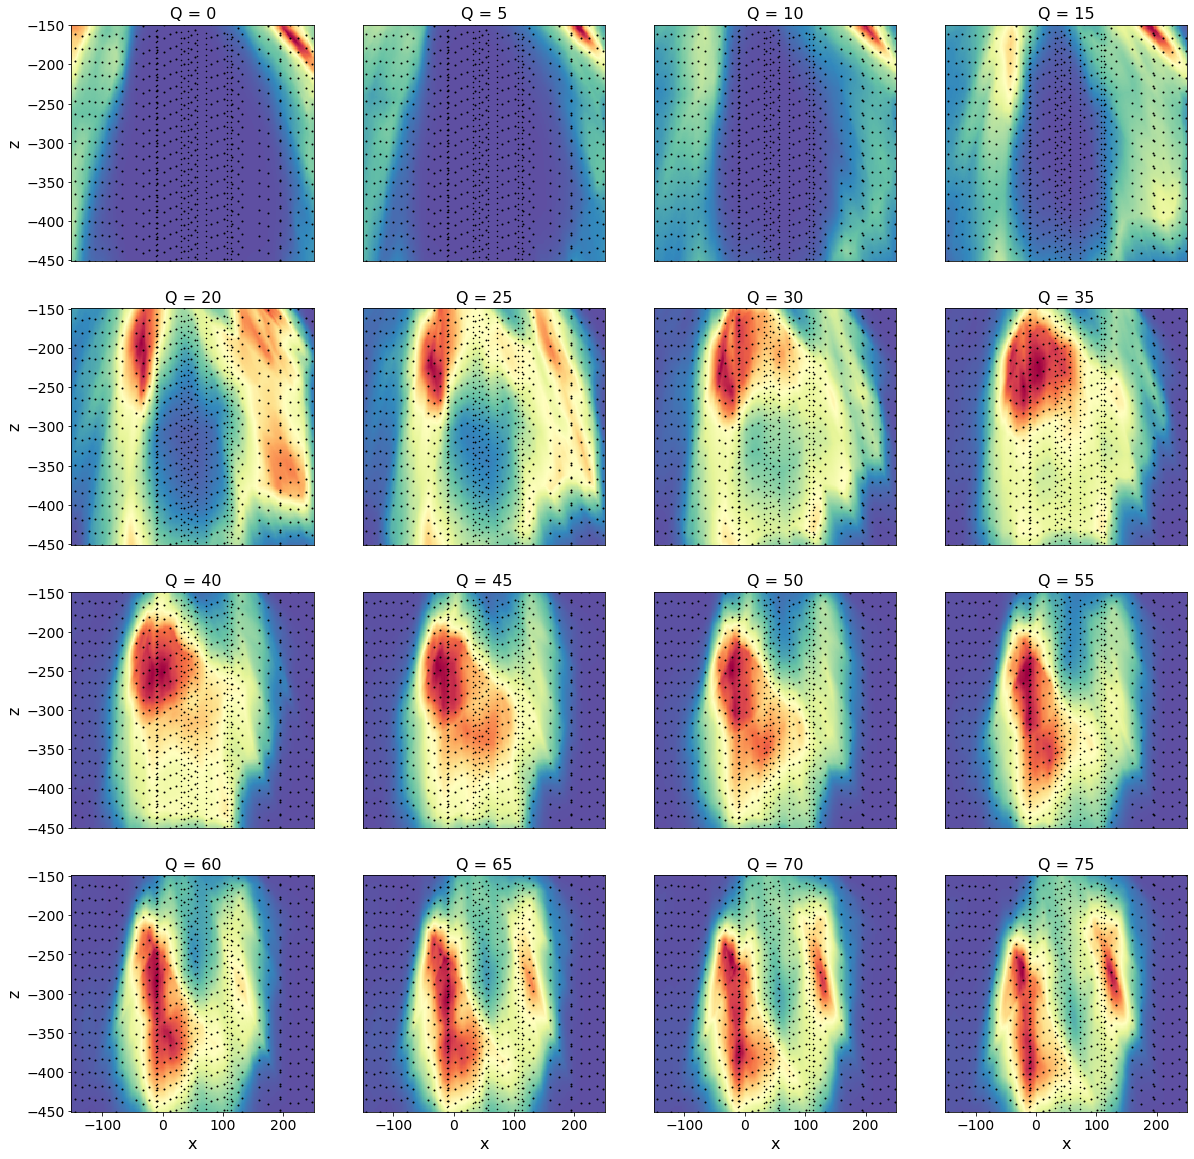

In [123]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))


N = 201

charges = np.linspace(0, 75, 16)


for i in range(len(charges)):
    
    g = dm.GridData(x = np.linspace(-150, 250, N), z= np.linspace(-450, -150, N))

    par = np.array([0., 0., 0., 0,0, 0, 25., 25.])

    p = np.repeat(par, N*N).reshape(8, -1).T
    p[:, 0] = g['x'].flatten()
    p[:, 2] = g['z'].flatten()
    _, l, q, _, = get_llhs(np.array([]), [charges[i]], [1.], p, epsilon = 1e-10, subtract=False)


    g['q'] = q.reshape(g.grid.shape)
    g['p'] = np.exp(-g['q'])

    axis = ax[i//4, i%4]
    
    g.plot('p', cmap='Spectral_r', ax=axis)
    axis.set_title('Q = %.0f'%charges[i])
    
    if not i//4 == 3:
        axis.get_xaxis().set_visible(False)
    if i%4:
        axis.get_yaxis().set_visible(False)
        
    
    
    axis.plot(geo[:78, :, 0], geo[:78, :, 2], 'o', color='k', ms=1)
    axis.plot(geo[78:, :, 0], geo[78:, :, 2], '*', color='k', ms=1)
        
#plt.savefig('cascade_25GeV.png')

# Optimization
We need a massively parallel optimization scheme in order to make use of the GPU's power, i.e. evaluate O(1000) llhs at once in every iteration

In [1617]:
N_individuals = 10000
event_idx = np.random.randint(0, len(pf)) #6666#3939 #2458

hits = hf[event_idx]
charges = qf[event_idx]
hitcharges = cf[event_idx]
truth = pf[event_idx]

In [1618]:
if len(hits) < 8: raise Exception()

In [1619]:
for t,l in zip(truth, labels):
    print(f'{l}: {t:.1f}')

x: 210.1
y: -55.4
z: -158.5
time: 9715.7
azimuth: 3.6
zenith: 2.6
cascade_energy: 431.7
track_energy: 111.5


In [1620]:
len(hits)

53

In [1621]:
def get_rand_params(N):
    params = np.random.rand(N, len(labels),)
    params[:, 0] = (params[:, 0] - 0.5) * 600
    params[:, 1] = (params[:, 1] - 0.5) * 600
    params[:, 2] = -params[:, 2] * 600
    params[:, 3] = (params[:, 3] - 0.5) * 1000 + 9500
    params[:, 4] *= 2*np.pi
    params[:, 5] *= np.pi
    params[:, 6] *= 100
    params[:, 7] *= 100 

    return params

In [1622]:
params = get_rand_params(N_individuals)

In [1623]:
opt_hist = []

In [1624]:
def run_generation(params):

    # eval fitness
    llhs, all_hits, q_llh, total_llh = get_llhs(hits, charges, hitcharges, params, subtract=False)
    
    opt_hist.append(np.min(total_llh))
    
    pool_size = 5
    
    # create selection pool
    sorted_llh_idx = np.argsort(total_llh)[::-1]
    ranks = (np.arange(N_individuals) + 1) * (np.arange(N_individuals)) / 2
    rand_r = np.random.rand(pool_size * N_individuals) * np.max(ranks)    
    d = np.digitize(rand_r, ranks)
    
    selection_pool_idx = sorted_llh_idx[d].reshape(pool_size, -1)
    selection_pool = params[selection_pool_idx]

    rand_r = rand_r.reshape(pool_size, -1)
    
    worst_mask = rand_r == np.min(rand_r, axis=0)
    worst_pool = selection_pool[worst_mask]
    
    # cross over
    from_mother = np.random.rand(*params.shape) < 0.5
    new_params = np.empty_like(params)
    new_params[from_mother] = selection_pool[0][from_mother]
    new_params[~from_mother] = selection_pool[1][~from_mother]

    # mutation
    
    mutate_all = get_rand_params(N_individuals)
    #mutate_all[4] = np.random.rand(l) * 2 * np.pi
    #mutate_all[5] = np.random.rand(l) * np.pi
    mutate_all[:,6] = np.clip((np.random.rand(N_individuals) + np.random.rand(N_individuals)) * params[:,6], a_min=1, a_max=1000)
    mutate_all[:,7] = np.clip((np.random.rand(N_individuals) + np.random.rand(N_individuals)) * params[:,7], a_min=0, a_max=1000)
    
    mutate = np.random.rand(*params.shape) < 0.1
    
    new_params[mutate] = mutate_all[mutate]
    
#     rand_params = get_rand_params(N_individuals)
    
#     new_params[mutate, 0:4] = rand_params[mutate, 0:4]
    
#     new_params[mutate, 4] = np.random.rand(l) * 2 * np.pi
#     new_params[mutate, 5] = np.random.rand(l) * np.pi
#     new_params[mutate, 6] = (np.random.rand(l) + np.random.rand(l)) * new_params[mutate, 6]
#     new_params[mutate, 7] = (np.random.rand(l) + np.random.rand(l)) * new_params[mutate, 7]
    
    # do some 1-d simplex ops
    simplex = np.random.rand(params.shape[0]) < 0.05
    new_params[simplex, 0:4] = 2 * (np.sum(selection_pool[:, simplex, 0:4], axis=0) - worst_pool[simplex, 0:4]) / 4. - worst_pool[simplex, 0:4]

    invalid = (new_params[:,0] < -500) | (new_params[:,0] > 500)
    new_params[invalid, 0] = params[invalid, 0]
    invalid = (new_params[:,1] < -500) | (new_params[:,1] > 500)
    new_params[invalid, 1] = params[invalid, 1]
    invalid = (new_params[:,2] < -700) | (new_params[:,2] > 300)
    new_params[invalid, 2] = params[invalid, 2]
    invalid = (new_params[:,3] < 8500) | (new_params[:,3] > 10500)
    new_params[invalid, 3] = params[invalid, 3]

    # and keep best individual alive
    # actually, no....this picks up some garbage
    #new_params[0] = params[np.argmin(total_llh)]
    
    return new_params

In [1625]:
N_gen = 300
with tqdm(total=N_gen) as pbar:
    for i in range(N_gen):
        params = run_generation(params)
        pbar.update(1)

 72%|███████▏  | 217/300 [00:44<00:15,  5.34it/s]/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
100%|██████████| 300/300 [01:01<00:00,  4.86it/s]


In [1639]:
#%lprun -f run_generation run_generation(params)

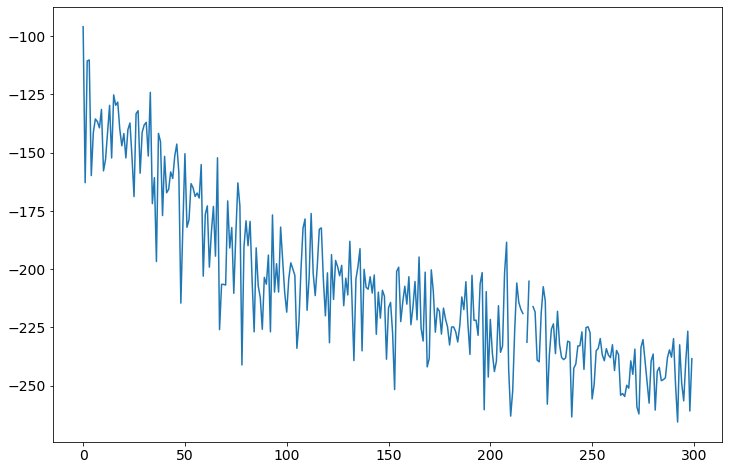

In [1626]:
plt.plot(opt_hist)

In [1627]:




llhs, all_hits, q_llh, total_llh = get_llhs(hits, charges, hitcharges, params, subtract=False)


In [1638]:
#%lprun -f get_llhs get_llhs(hits, charges, hitcharges, params, subtract=False)

In [1628]:
ok_mask = total_llh < np.min(total_llh) + 10

In [1642]:
%%timeit
_, _, _, true_llh = get_llhs(hits, charges, hitcharges, truth, subtract=False)


67.4 ms ± 905 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1643]:
%lprun -f get_llhs get_llhs(hits, charges, hitcharges, truth, subtract=False)

Timer unit: 1e-06 s

Total time: 0.180345 s
File: <ipython-input-491-eb7daebcb669>
Function: get_llhs at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_llhs(hits, charges, hitcharges, params, epsilon = 1e-10, subtract=True):
     2                                               
     3         1          4.0      4.0      0.0      if params.ndim == 1:
     4         1         27.0     27.0      0.0          params = np.array([params])
     5                                               
     6         1          2.0      2.0      0.0      N = params.shape[0]
     7         1          1.0      1.0      0.0      n_hits = hits.shape[0]
     8                                               
     9         1         37.0     37.0      0.0      q_charges = np.repeat(charges, repeats=N)
    10         1      81457.0  81457.0     45.2      q_llh = charge_net.predict([q_charges[:, np.newaxis], params], batch_size=40

In [1641]:
true_llh

array([-139.77798], dtype=float32)

In [1630]:
weighted_quantile(np.ones(10), weights=np.ones(10), q=[0.5, 0.6])

array([1., 1.])

In [1631]:
best = params[np.argmin(total_llh)]
print('                     reco       median   wm    truth')
print('---------------------------------------------------------')
for i, label in enumerate(labels):
    wm = weighted_quantile(params[ok_mask][:,i], weights=np.exp(- total_llh[ok_mask] + np.min(total_llh[ok_mask])), q=[0.5,])[0]
    print(f'{label.ljust(20)}: {best[i]:.1f}\t{np.median(params[ok_mask][:,i]):.1f}\t{wm:.1f}\t{truth[i]:.1f}')

                     reco       median   wm    truth
---------------------------------------------------------
x                   : 124.4	124.4	124.4	210.1
y                   : -38.4	-38.4	-38.4	-55.4
z                   : -517.3	-517.3	-517.3	-158.5
time                : 8525.0	8525.0	8525.0	9715.7
azimuth             : 3.1	3.1	3.1	3.6
zenith              : 3.0	3.0	3.0	2.6
cascade_energy      : 56.5	56.5	56.5	431.7
track_energy        : 177.4	177.4	177.4	111.5


/home/iwsatlas1/peller/dragoman/dragoman/utils/stats.py:82: RuntimeWarning: divide by zero encountered in true_divide
  edges /= total_width
/home/iwsatlas1/peller/dragoman/dragoman/utils/stats.py:83: RuntimeWarning: invalid value encountered in true_divide
  midpoints = midpoints / total_width


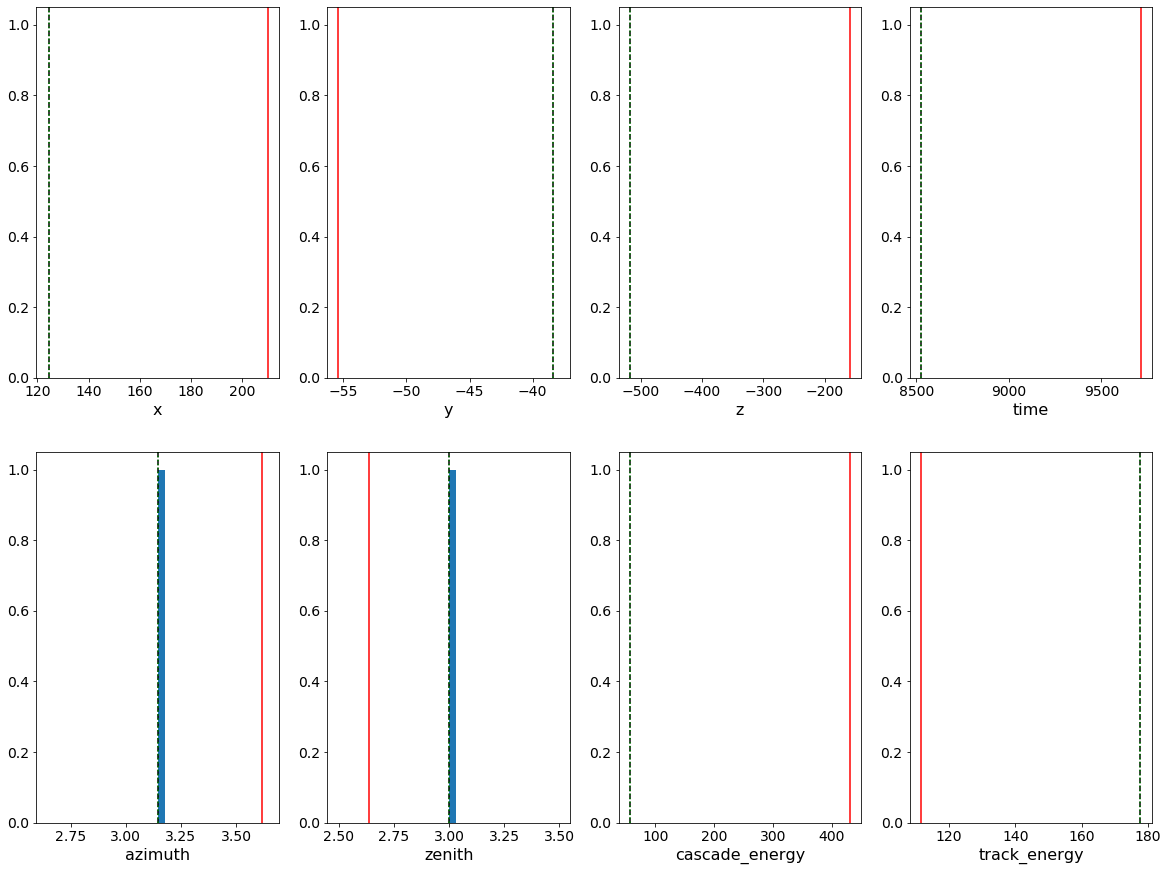

In [1632]:
fig, ax = plt.subplots(2, 4, figsize=(20, 15))

for i, label in enumerate(labels):
    axis = ax[i//4, i%4]
    axis.hist(params[ok_mask][:,i], bins=30)
    axis.set_xlabel(label)
    axis.axvline(truth[i], c='r')
    axis.axvline(best[i], c='k', ls='--')
    axis.axvline(np.median(params[ok_mask][:,i]), c='g', ls=':')